<center>
<img src="../../img/ods_stickers.jpg">
## <center>Открытый курс по машинному обучению
<center> Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий



# <center>Домашнее задание 7. <br> Метод главных компонент, t-SNE и кластеризация. Решение</center>

В этой домашней работе мы  попрактикуемся в снижении размерности, визуализации и кластеризации данных, встроенных в `sklearn`. Ответы на вопросы заполните в [веб-форме](https://docs.google.com/forms/d/e/1FAIpQLSdjgje8qvptEW1EKY-QBbHXmXGIs6QYK2PqhchzF4Kpg3v8OQ/viewform?usp=sf_link).

## 1. PCA

Начнём с того, что импортируем все необходимые модули

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style='white')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.model_selection import train_test_split

Дана игрушечная выборка. 

In [2]:
X = np.array([[2., 13.], [1., 3.], [6., 19.],
              [7., 18.], [5., 17.], [4., 9.],
              [5., 22.], [6., 11.], [8., 25.]])

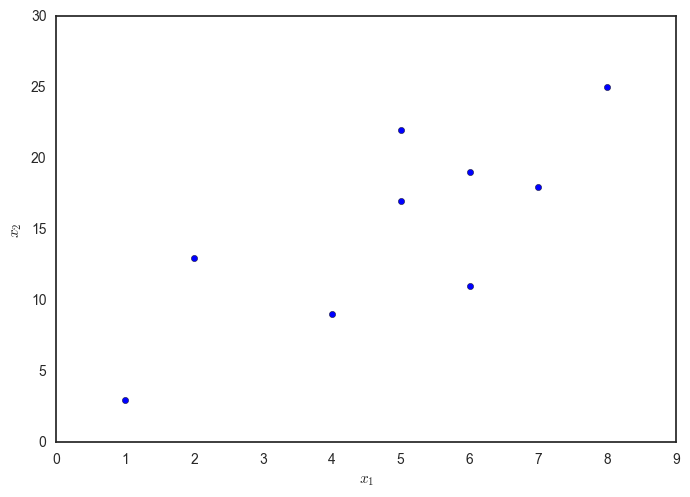

In [3]:
plt.scatter(X[:,0], X[:, 1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$');

<font color='red'>Вопрос 1. </font>На сколько градусов относительно оси $x_1$ повернут вектор, задающий 1 главную компоненту в этих данных (на забудьте отмасштабировать выборку)? 
- 30 градусов
- 45 градусов
- 60 градусов
- 75 градусов

In [4]:
from scipy.linalg import svd

X_scaled = StandardScaler().fit_transform(X)
U, Sigma, VT = svd(X_scaled)

In [5]:
VT

array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]])

<font color='red'>Ответ 1.</font> 45 градусов

<font color='red'>Вопрос 2. </font> Каковы собственные значения матрицы $X^TX$, где $X$ – матрица, соответствующая отмасштабированной выборке. В чем смысл этих двух чисел? 

 - 4 и 1.42
 - 16.2 и 2702.8
 - 4.02 и 51.99
 - 15.97 и 2.03

In [6]:
np.linalg.eig(X_scaled.T.dot(X_scaled))[0]

array([ 15.96987204,   2.03012796])

<font color='red'>Ответ 2. </font> 15.97 и 2.03

<font color='red'>Вопрос 3. </font> В чем смысл двух чисел из прошлого вопроса? 

- их квадраты говорят о том, какую часть дисперсии исходных данных объясняют главные компоненты
- они задают угол, на который 1-я главная компонента повернута относительно исходных координат
- эти числа говорят о том, какую часть дисперсии исходных данных объясняют главные компоненты
- корни из этих чисел задают угол, на который 1-я главная компонента повернута относительно исходных координат

<font color='red'>Ответ 3. </font> эти числа говорят о том, какую часть дисперсии исходных данных объясняют главные компоненты

Загрузим датасет с лицами и выведем имена

In [7]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, 
                resize=0.4, data_home='../../data/faces')

print('%d objects, %d features, %d classes' % (lfw_people.data.shape[0],
      lfw_people.data.shape[1], len(lfw_people.target_names)))
print('\nPersons:')
for name in lfw_people.target_names:
    print(name)

1560 objects, 1850 features, 12 classes

Persons:
Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Jacques Chirac
Jean Chretien
John Ashcroft
Junichiro Koizumi
Serena Williams
Tony Blair


Посмотрим на содержимое датасета. Все изображения лежат в удобном lfw_people.images

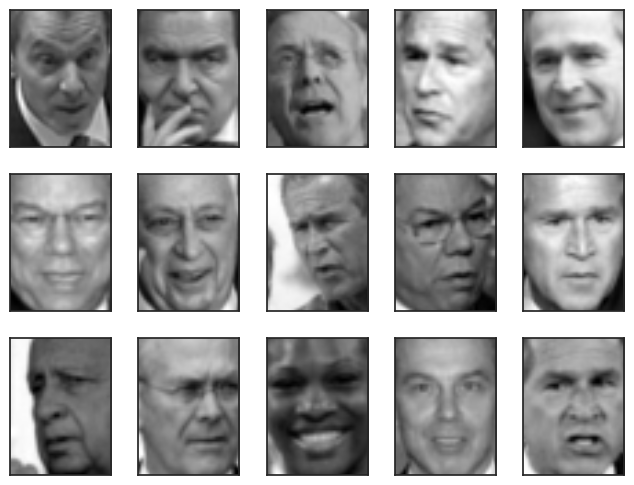

In [8]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='gray')

<font color='red'>Вопрос 4. </font>Какое **минимальное** число компонент PCA необходимо, чтобы объяснить 90% дисперсии масштабированных (при помощи StandardScaler) данных?

- 75
- 76
- 77
- 78

Для PCA в данной задаче стоит использовать параметр [`svd_solver='randomized'`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), который является приближением PCA, но позволяет существенно ускорить его работу на больших наборах данных. Для того, чтобы результаты можно было сравнивать, нужно зафиксировать `random_state=1`.

78 principal components explain 90.14% of variance


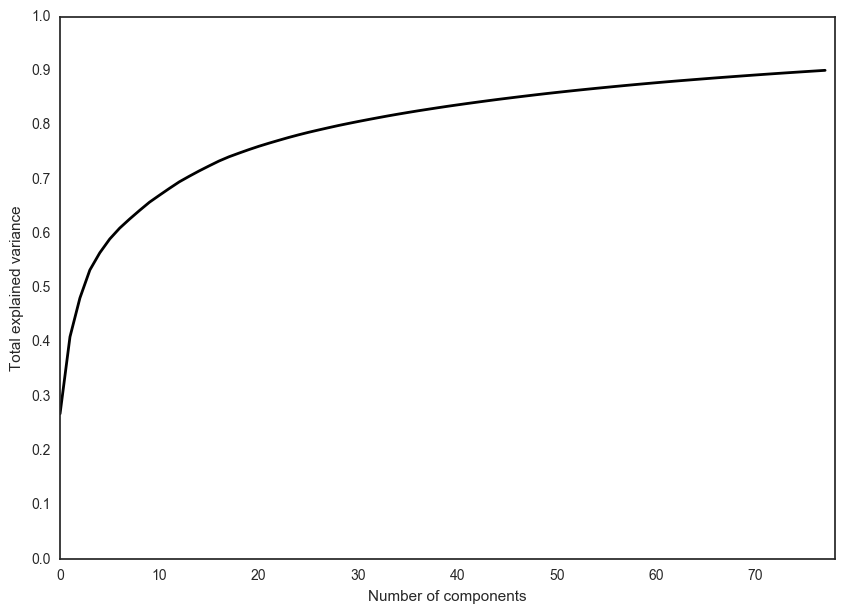

In [9]:
pca = PCA(n_components=78, svd_solver='randomized', random_state=1)

scaler = StandardScaler()
faces_scaled = scaler.fit_transform(lfw_people.data)

pca.fit(faces_scaled)

print('%d principal components explain %.2f%% of variance' %
      (pca.n_components_, 100 * np.cumsum(pca.explained_variance_ratio_)[-1]))
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=2, color='k')
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 78)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [10]:
np.cumsum(pca.explained_variance_ratio_)[-4:]

array([ 0.89784291,  0.89903903,  0.90021131,  0.9013692 ])

<font color='red'>Ответ 4. </font> 77.

Постройте картинку, на которой изображены первые 30 главных компонент (только не пугайтесь, когда увидите, что получилось). Для этого надо эти 30 векторов взять из `pca.components_`, трансформировать опять по размеру исходных изображений (50 x 37) и нарисовать.

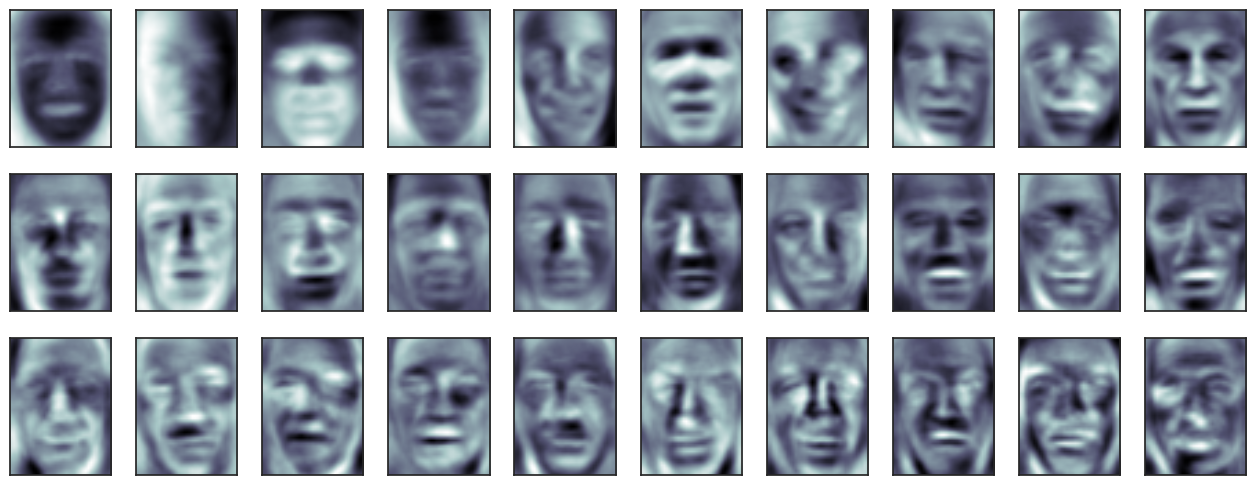

In [11]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((50, 37)), cmap='bone')

<font color='red'>Вопрос 5. </font> Какие из первых 30 главных компонент сильнее всего "отвечает" за освещенность лица слева. Конкретней: для какой главной компоненты линейная комбинация исходных признаков (интенсивностей пикселов), если ее представить как изображение, выглядит, как фотография, ярко освещенная слева.

- 1
- 2
- 4
- 5

<font color='red'>Ответ 5. </font> 2-я главная компонента.

Теперь давайте построим проекцию лиц в пространство главных компонент с числом компонент равным 2.

<font color='red'>Вопрос 6. </font> Кто меньше всего похож на других людей в выборке, если выделять 2 главные компоненты? Для ответа на этот вопрос выделите 2 главные компоненты в масштабированных данных (используйте опять  параметр `svd_solver='randomized'` и `random_state=1`), посчитайте для каждого человека в выборке среднее значение 2 главных компонент всех его фотографий, затем из 12 2-мерных точек найдите наиболее удаленную от остальных (по среднему евклидову расстоянию до других точек). Можно это делать точно, а можно и на глаз с помощью `sklearn.metrics.euclidean_distances` и `seaborn.heatmap`.

- Колин Пауэлл
- Джордж Буш
- Жак Ширак
- Серена Уильямс

In [12]:
lfw_people.target_names, len(lfw_people.target_names)

(array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
        'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac',
        'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi',
        'Serena Williams', 'Tony Blair'], 
       dtype='<U17'), 12)

In [13]:
pca = PCA(n_components=2, svd_solver='randomized', random_state=1)
pca.fit(faces_scaled)

mean_face_centers = []

for i, name in enumerate(lfw_people.target_names):   
    cloud = pca.transform(faces_scaled[lfw_people.target == i])
    mean_face_centers.append(cloud.mean(axis=0))

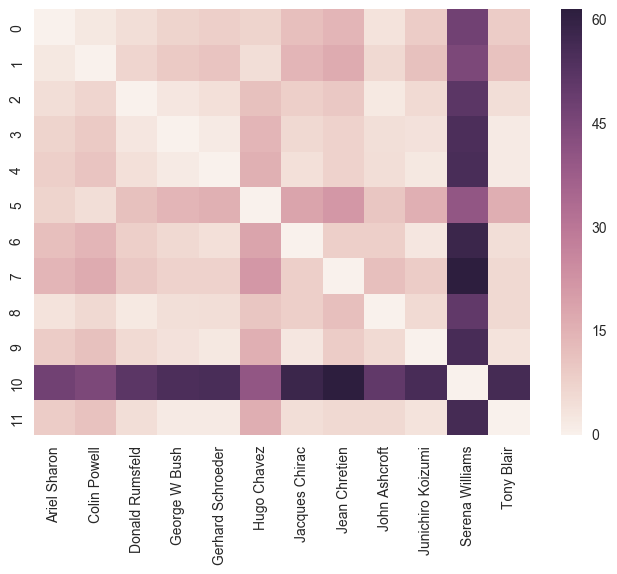

In [14]:
from sklearn.metrics import euclidean_distances

sns.heatmap(euclidean_distances(mean_face_centers))
plt.xticks(np.arange(12) + 0.5, lfw_people.target_names, rotation='vertical');

<font color='red'>Ответ 6. </font> Серена Уильямс.

## 2. t-SNE

Возьмём упомянутый в статье способ визуализации данных с помощью [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) и посмотрим на наши лица на плоскости. При использовании `n_components=2` и `random_state=1` в левом верхнем углу проекции образуется кластер из лиц, относящихся к одному человеку. 

<font color='red'>Вопрос 7. </font> Какому человеку из набора данных lfw_people соответствуют два выброса в правом верхнем углу проекции t-SNE с параметрами `n_components=2` и `random_state=1`?

- Серена Уильямс
- Уго Чавес
- Джордж Буш
- Жак Ширак

In [15]:
%%time
tsne = TSNE(n_components=2, random_state=1)
faces_tsne = tsne.fit_transform(faces_scaled)

Wall time: 16.3 s


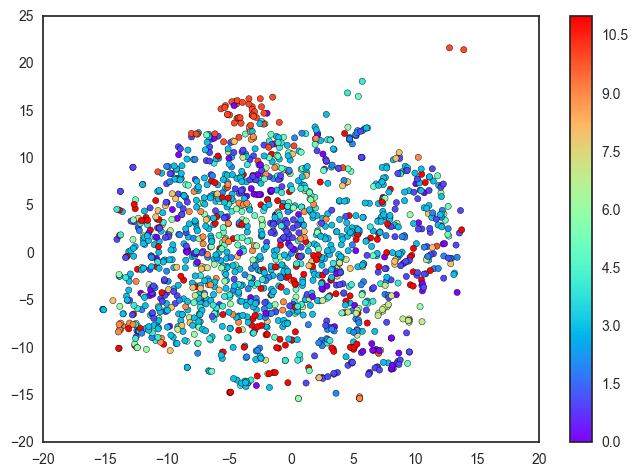

In [16]:
plt.scatter(faces_tsne[:, 0], faces_tsne[:, 1], 
            c=lfw_people.target, cmap='rainbow')
plt.colorbar();

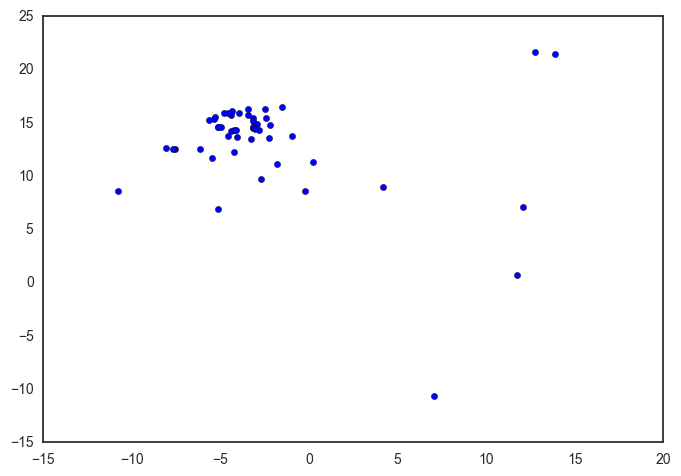

In [17]:
plt.scatter(faces_tsne[lfw_people.target == 10, 0], 
            faces_tsne[lfw_people.target == 10, 1]);

In [18]:
print(lfw_people.target_names[10])

Serena Williams


<font color='red'>Ответ 7. </font> Серена Уильямс.

## 3. Кластеризация

Для следующего вопроса загрузим набор данных с ценами на жильё:

In [19]:
boston = datasets.load_boston()
X = boston.data

Найдем с помощью метода локтя (см. 7 [статью](https://habrahabr.ru/company/ods/blog/325654/) курса) оптимальное число кластеров, которое стоит задать алгоритму kMeans в качестве гиперпараметра. 

<font color='red'>Вопрос 8. </font> Каким будет оптимальное число кластеров для датасета с ценами на жильё, если оценивать его с помощью метода локтя? Используйте в kMeans `random_state=1`, данные не масштабируйте.

- 2
- 3
- 4
- 5

В данном случае мы ищем наиболее выделеный излом в кривой расстояний до цетроидов в зависимости от числа кластеров. Будем рассматривать возможное число кластеров от 2 до 10. Как и в предыдущей задаче, нужно будет использовать `random_state=1` для инициализации алгоритма k-means.

k=  2 0.324921165437
k=  3 0.624948868292
k=  4 0.327756116816
k=  5 1.01811466336
k=  6 0.631535222331
k=  7 0.680701620167
k=  8 0.906729749781


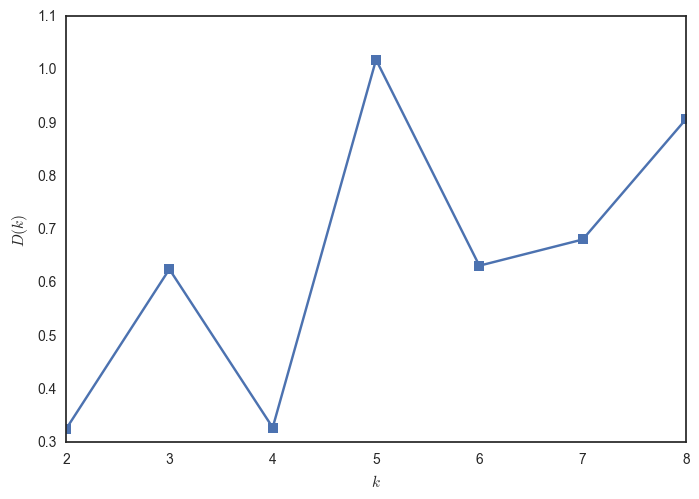

In [20]:
from sklearn.cluster import KMeans

func = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    func.append(np.sqrt(kmeans.inertia_))


scores=[]
for i in range(1,8):
    scores.append((func[i]-func[i+1])/(func[i-1]-func[i]))
    print("k= ",i+1 , scores[i-1])

    
plt.plot(range(2, 9), scores, marker='s') 
plt.xlabel('$k$')
plt.ylabel('$D(k)$')

###### Ответ 8: k=2.

In [39]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

In [40]:
algorithms = [KMeans(n_clusters=12, random_state=1),
              AffinityPropagation(),
              SpectralClustering(n_clusters=12, random_state=1,
                                     affinity='nearest_neighbors'),
              AgglomerativeClustering(n_clusters=12)]

res = []
for algo in algorithms:
    algo.fit(faces_scaled)
    res.append(({
        'ARI': metrics.adjusted_rand_score(lfw_people.target, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(lfw_people.target, algo.labels_),
        'Homogenity': metrics.homogeneity_score(lfw_people.target, algo.labels_),
        'Completeness': metrics.completeness_score(lfw_people.target, algo.labels_),
        'V-measure': metrics.v_measure_score(lfw_people.target, algo.labels_),
        'Silhouette': metrics.silhouette_score(faces_scaled, algo.labels_)}))

In [41]:
results = pd.DataFrame(data=res, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['KMeans', 'Affinity', 
                              'Spectral', 'Agglomerative'])

In [42]:
results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
KMeans,0.027093,0.068304,0.095802,0.083819,0.089410,0.044945
Affinity,0.014616,0.086747,0.305615,0.154552,0.205288,0.019190
Spectral,0.011699,0.067703,0.086099,0.094563,0.090133,-0.050495
Agglomerative,0.027382,0.073197,0.099838,0.089044,0.094132,0.025744


<font color='red'>Вопрос 9. </font> Выберите все верные утверждения:

- Агломеративная кластеризация справилась лучше всех других алгоритмов по всем метрикам качества
- Результаты кластеризации неудовлетворительные, ни одна из метрики не превышает 35%
- Affinity Propagation сработала лучше спектральной кластеризации по всем метрикам качества
- Если выделять только 2 кластера, а результаты кластеризации сравнивать с бинарным вектором, Серена Уильямс это или нет, то в целом алгоритмы справляются лучше, некоторые метрики превышают значение в 66%

In [43]:
algorithms2 = [KMeans(n_clusters=2, random_state=1),
              AffinityPropagation(),
              SpectralClustering(n_clusters=2, random_state=1,
                                     affinity='nearest_neighbors'),
              AgglomerativeClustering(n_clusters=2)]

is_serena = (lfw_people.target == 10).astype('int')

res2 = []
for algo in algorithms2:
    algo.fit(faces_scaled)
    res2.append(({
        'ARI': metrics.adjusted_rand_score(is_serena, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(is_serena, algo.labels_),
        'Homogenity': metrics.homogeneity_score(is_serena, algo.labels_),
        'Completeness': metrics.completeness_score(is_serena, algo.labels_),
        'V-measure': metrics.v_measure_score(is_serena, algo.labels_),
        'Silhouette': metrics.silhouette_score(faces_scaled, algo.labels_)}))
    
results2 = pd.DataFrame(data=res2, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['KMeans', 'Affinity', 
                              'Spectral', 'Agglomerative'])
results2

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
KMeans,0.027811,0.042521,0.200508,0.042976,0.070781,0.145569
Affinity,0.001555,0.017287,0.675966,0.023447,0.045322,0.019190
Spectral,0.179523,0.086187,0.288566,0.086801,0.133458,0.142323
Agglomerative,0.026231,0.037344,0.176463,0.037801,0.062264,0.119324


Если без масштабирования – ответы все равно те же.

In [46]:
algorithms = [KMeans(n_clusters=12, random_state=1),
              AffinityPropagation(),
              SpectralClustering(n_clusters=12, random_state=1,
                                     affinity='nearest_neighbors'),
              AgglomerativeClustering(n_clusters=12)]

res = []
for algo in algorithms:
    algo.fit(lfw_people.data)
    res.append(({
        'ARI': metrics.adjusted_rand_score(lfw_people.target, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(lfw_people.target, algo.labels_),
        'Homogenity': metrics.homogeneity_score(lfw_people.target, algo.labels_),
        'Completeness': metrics.completeness_score(lfw_people.target, algo.labels_),
        'V-measure': metrics.v_measure_score(lfw_people.target, algo.labels_),
        'Silhouette': metrics.silhouette_score(faces_scaled, algo.labels_)}))

In [47]:
results = pd.DataFrame(data=res, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['KMeans', 'Affinity', 
                              'Spectral', 'Agglomerative'])

In [48]:
results

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
KMeans,0.020851,0.065449,0.092717,0.080958,0.086439,0.042901
Affinity,0.011917,0.070108,0.276269,0.138634,0.184623,0.011374
Spectral,0.009477,0.065966,0.084370,0.090947,0.087535,-0.053306
Agglomerative,0.016692,0.060287,0.086180,0.076155,0.080858,0.009255


In [49]:
algorithms2 = [KMeans(n_clusters=2, random_state=1),
              AffinityPropagation(),
              SpectralClustering(n_clusters=2, random_state=1,
                                     affinity='nearest_neighbors'),
              AgglomerativeClustering(n_clusters=2)]

is_serena = (lfw_people.target == 10).astype('int')

res2 = []
for algo in algorithms2:
    algo.fit(lfw_people.data)
    res2.append(({
        'ARI': metrics.adjusted_rand_score(is_serena, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(is_serena, algo.labels_),
        'Homogenity': metrics.homogeneity_score(is_serena, algo.labels_),
        'Completeness': metrics.completeness_score(is_serena, algo.labels_),
        'V-measure': metrics.v_measure_score(is_serena, algo.labels_),
        'Silhouette': metrics.silhouette_score(faces_scaled, algo.labels_)}))
    
results2 = pd.DataFrame(data=res2, columns=['ARI', 'AMI', 'Homogenity',
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['KMeans', 'Affinity', 
                              'Spectral', 'Agglomerative'])
results2

,ARI,AMI,Homogenity,Completeness,V-measure,Silhouette
KMeans,0.027111,0.042255,0.199435,0.042710,0.070353,0.142970
Affinity,0.001505,0.016969,0.672058,0.023132,0.044724,0.011374
Spectral,0.171740,0.080125,0.269952,0.080740,0.124302,0.142148
Agglomerative,0.015702,0.033423,0.159867,0.033877,0.055907,0.108713


<font color='red'>Ответ 9. </font> Все, кроме первого

Возьмите полученные раннее координаты 12 "средних" изображений людей. Постройте для них дендрограмму. Используйте  `scipy.cluster.hierarchy` и `scipy.spatial.distance.pdist`, параметры возьмите такие же, как в соответствующем примере в [статье](https://habrahabr.ru/company/ods/blog/325654/).

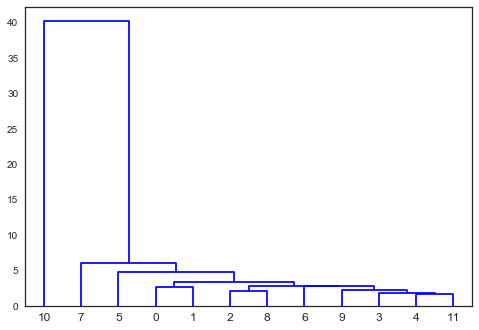

In [44]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

distance_mat = pdist(mean_face_centers) 

Z = hierarchy.linkage(distance_mat, 'single') 
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

<font color='red'>Вопрос 10. </font> Какому человеку соответствует точка, объединившаяся с другими при построеннии дендрограммы **предпоследней**?

- Gerhard Schroeder
- Jean Chretien
- John Ashcroft
- Junichiro Koizumi

In [45]:
lfw_people.target_names[7]

'Jean Chretien'

<font color='red'>Ответ 10. </font> Jean Chretien.